In [1]:
# load 

import sys
import glob
sys.path.append('/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction')

import time
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import cross_val_score,train_test_split
from utils.utils_mine import*
import tensorflow as tf
import tensorflow.keras as keras
from datetime import date
import numpy as np
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import pingouin as pg
import subprocess


/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.14.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issu

In [7]:
# path of data 


def read_from_file(example_path): # Open the file and read through the first few lines to find where the data starts
    with open(example_path, 'r') as file:
        lines = file.readlines()
        data_start_line = None
        for i, line in enumerate(lines):
            if 'Data' in line:  # This should match the unique identifier of the data section
                data_start_line = i + 1
                # print(lines[data_start_line])
                break

    if data_start_line is not None:

        # Read the data section, skipping the lines of the metadata
        data = pd.read_csv(example_path, skiprows=data_start_line)

        # Now you have metadata and data as separate DataFrames
        # print(data)
    else:
        print("Data section not found.")
        
    np_data = data.to_numpy()
    ch_data = np_data[:, 1:1+52]

    return ch_data

def get_file_name(path, rest):
    file_pattern = os.path.join(path, rest)
    file_list = glob.glob(file_pattern)
    return file_list




# find all subject from T8 in Baselin and construct an array
There are 46 MDD subjects that have both baseline and T8 time fNIRS data 

In [3]:
follow_up_fold = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/cyrus_follow-up/data-information'
T8_path = follow_up_fold + '/T8_fnirs/Session 2_VFT'
base_patient_path = follow_up_fold + '/Baseline_fnirs/Patients'
cli_path = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/cyrus_follow-up/data-information/fNIRS x MDD Data_Demographics_Clinical.xlsx'

excel_data = pd.read_excel(cli_path, sheet_name='Summary T0T8_fNIRS Analysis')
label_hamd = []

for hb in ['_Oxy.csv', '_Deoxy.csv']:
    tmp = 0
    all_subject = []
    for i in os.listdir(T8_path):
        if i[-len(hb):] == hb:
            subject = i.split(' ')[0]
            all_subject.append(subject)
            file_pattern = os.path.join(base_patient_path, subject+'*'+hb)
            file_list = glob.glob(file_pattern)
            if len(file_list) < 1:
                print(file_list)
            tmp+=1
    all_subject.sort()
    print(f'all_subject -> {all_subject}')
    


# according to the subject name of all_subject create array now 

mdd_subject_base_t8 = np.zeros((len(all_subject), 1251, 52, 2, 2)) # time, channel, hbo/hbr, base/t8

for sub_index, subject in enumerate(all_subject):
    hamd_of_id_t1 = excel_data[excel_data['Subject ID'] == subject]['HAM-D Questionnaire (T1)'].iloc[0]
    hamd_of_id_t8 = excel_data[excel_data['Subject ID'] == subject]['HAM-D Questionnaire (T8)'].iloc[0]
    sub_label = [hamd_of_id_t1, hamd_of_id_t8]
    label_hamd.append(sub_label)
    for hb_index, hb in enumerate(['_Oxy.csv', '_Deoxy.csv']):

        base_hb_file = get_file_name(base_patient_path, subject+'*'+hb)
        base_hb = read_from_file(base_hb_file[0])
        
        t8_hb_file = get_file_name(T8_path, subject+'*'+hb)
        t8_hb = read_from_file(t8_hb_file[0])

        hb = np.concatenate((base_hb[...,np.newaxis], t8_hb[...,np.newaxis]), axis=-1)
        mdd_subject_base_t8[sub_index,:,:,hb_index,:] = hb

label_hamd = np.array(label_hamd)
print(f'mdd_subject_base_t8 -> {mdd_subject_base_t8.shape}')

print(f'label_hamd -> {label_hamd.shape}')

all_subject -> ['PT002', 'PT003', 'PT005', 'PT006', 'PT008', 'PT009', 'PT010', 'PT011', 'PT012', 'PT013', 'PT014', 'PT015', 'PT016', 'PT017', 'PT018', 'PT019', 'PT021', 'PT022', 'PT023', 'PT024', 'PT025', 'PT026', 'PT027', 'PT028', 'PT029', 'PT030', 'PT031', 'PT032', 'PT033', 'PT034', 'PT036', 'PT037', 'PT038', 'PT039', 'PT040', 'PT041', 'PT042', 'PT043', 'PT044', 'PT045', 'PT046', 'PT048', 'PT049', 'PT050', 'PT051', 'PT054']
all_subject -> ['PT002', 'PT003', 'PT005', 'PT006', 'PT008', 'PT009', 'PT010', 'PT011', 'PT012', 'PT013', 'PT014', 'PT015', 'PT016', 'PT017', 'PT018', 'PT019', 'PT021', 'PT022', 'PT023', 'PT024', 'PT025', 'PT026', 'PT027', 'PT028', 'PT029', 'PT030', 'PT031', 'PT032', 'PT033', 'PT034', 'PT036', 'PT037', 'PT038', 'PT039', 'PT040', 'PT041', 'PT042', 'PT043', 'PT044', 'PT045', 'PT046', 'PT048', 'PT049', 'PT050', 'PT051', 'PT054']
mdd_subject_base_t8 -> (46, 1251, 52, 2, 2)
label_hamd -> (46, 2)


In [45]:
save_fold = '/Users/shanxiafeng/Documents/Code/python/fnirs_DL/JinyuanWang_pythonCode/allData/prognosis'
np.save(save_fold + '/data', mdd_subject_base_t8)
np.save(save_fold + '/label', label_hamd)


# For the baseline time subject, we have 71 subjects data.

In [11]:
follow_up_fold = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/cyrus_follow-up/data-information'
T8_path = follow_up_fold + '/T8_fnirs/Session 2_VFT'
base_patient_path = follow_up_fold + '/Baseline_fnirs/Patients'
cli_path = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/cyrus_follow-up/data-information/fNIRS x MDD Data_Demographics_Clinical.xlsx'

excel_data = pd.read_excel(cli_path, sheet_name='Summary T0T8_fNIRS Analysis')
label_hamd = []
demoprafic_data = []
for hb in ['_Oxy.csv', '_Deoxy.csv']:
    tmp = 0
    all_subject = []
    for i in os.listdir(base_patient_path):
        if i[-len(hb):] == hb:
            subject = i.split(' ')[0]
            all_subject.append(subject)
            file_pattern = os.path.join(base_patient_path, subject+'*'+hb)
            file_list = glob.glob(file_pattern)
            if len(file_list) < 1:
                print(file_list)
            tmp+=1
    all_subject.sort()
    print(f'all_subject -> {all_subject}')
print(f'all_subject -> {len(all_subject)}')

# def get_file_name(path, rest):
#     file_pattern = os.path.join(path, rest)
#     file_list = glob.glob(file_pattern)
#     return file_list
# # according to the subject name of all_subject create array now 

mdd_subject_base = []#np.zeros((len(all_subject), 1251, 52, 2)) # time, channel, hbo/hbr

for sub_index, subject in enumerate(all_subject):
    hamd_of_id_t1 = excel_data[excel_data['Subject ID'] == subject]['HAM-D Questionnaire (T1)'].iloc[0]
    hamd_of_id_t8 = excel_data[excel_data['Subject ID'] == subject]['HAM-D Questionnaire (T8)'].iloc[0]
    demographic = excel_data[excel_data['Subject ID'] == subject].iloc[:, 2:13]
    if type(hamd_of_id_t8) is not int:
        print(hamd_of_id_t8)
        continue
    sub_label = [hamd_of_id_t1, hamd_of_id_t8]
    label_hamd.append(sub_label)
    demoprafic_data.append(demographic)
    hbo_hbr = np.zeros((1251, 52, 2))
    for hb_index, hb in enumerate(['_Oxy.csv', '_Deoxy.csv']):

        base_hb_file = get_file_name(base_patient_path, subject+'*'+hb)
        base_hb = read_from_file(base_hb_file[0])
        hbo_hbr[...,hb_index] = base_hb
    mdd_subject_base.append(hbo_hbr)
mdd_subject_base = np.array(mdd_subject_base)
label_hamd = np.array(label_hamd)
demoprafic_data = np.squeeze(np.array(demoprafic_data))


print(f'mdd_subject_base -> {mdd_subject_base.shape}')
print(f'label_hamd -> {label_hamd.shape}')
print(f'demoprafic_data -> {demoprafic_data.shape}')

all_subject -> ['PT001', 'PT002', 'PT003', 'PT004', 'PT005', 'PT006', 'PT008', 'PT009', 'PT010', 'PT011', 'PT012', 'PT013', 'PT014', 'PT015', 'PT016', 'PT017', 'PT018', 'PT019', 'PT020', 'PT021', 'PT022', 'PT023', 'PT024', 'PT025', 'PT026', 'PT027', 'PT028', 'PT029', 'PT030', 'PT031', 'PT032', 'PT033', 'PT034', 'PT035', 'PT036', 'PT036', 'PT037', 'PT038', 'PT039', 'PT040', 'PT041', 'PT042', 'PT043', 'PT044', 'PT045', 'PT046', 'PT047', 'PT048', 'PT049', 'PT050', 'PT051', 'PT052', 'PT053', 'PT054', 'PT055', 'PT056', 'PT057', 'PT058', 'PT059', 'PT060', 'PT061', 'PT062', 'PT063', 'PT064', 'PT065', 'PT066', 'PT067', 'PT068', 'PT069', 'PT070', 'PT071']
all_subject -> ['PT001', 'PT002', 'PT003', 'PT004', 'PT005', 'PT006', 'PT008', 'PT009', 'PT010', 'PT011', 'PT012', 'PT013', 'PT014', 'PT015', 'PT016', 'PT017', 'PT018', 'PT019', 'PT020', 'PT021', 'PT022', 'PT023', 'PT024', 'PT025', 'PT026', 'PT027', 'PT028', 'PT029', 'PT030', 'PT031', 'PT032', 'PT033', 'PT034', 'PT035', 'PT036', 'PT036', 'PT03

In [46]:
label_responder = np.zeros(label_hamd.shape[0])
for i, val in enumerate(label_hamd):
    if (val[1] - val[0]) / val[0] <= -0.5:
        label_responder[i] = 1
        # print('label_responder[i] -> ', label_responder[i])
        # print('val -> ',val)
print(label_responder)
count = np.count_nonzero(label_responder == 1)
print(count)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
15


In [21]:
hb = np.empty((65,1251,52,3))
hb[...,0:2] = mdd_subject_base
hb[..., -1:] = mdd_subject_base[...,0:1] + mdd_subject_base[...,1:2]

In [47]:
print(hb.shape)
save_pretreatment_data_fold = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/prognosis/pre_treatment_hamd_reduction_50'

np.save(save_pretreatment_data_fold + '/hb_data', hb)
np.save(save_pretreatment_data_fold + '/label', label_responder)
np.save(save_pretreatment_data_fold + '/demographic_data', demoprafic_data)

(65, 1251, 52, 3)


21.68178749


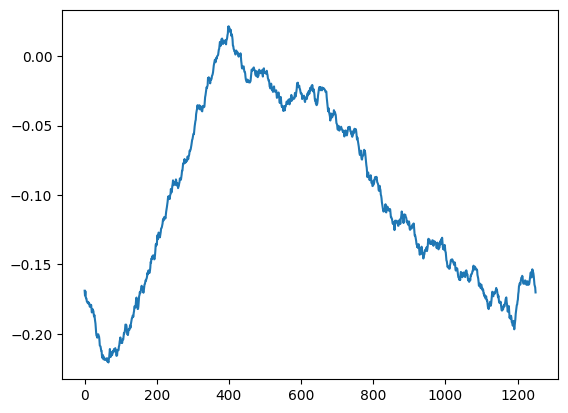

In [33]:
hbt_mean = np.mean(hb[...,0],axis=(0,2)) 
plt.plot(hbt_mean)


In [ ]:
data_gab = np.load('/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/dataset_514/gabrielle_num_of_sub_141/hb_data.npy')
print(data_gab.shape)
for i in range(data_gab.shape[0]):
    plt.figure()
    plt.title('subject -> ' + str(i))
    mean_hbo = np.mean(data_gab[i,:,:,0], axis=0)
    mean_hbr = np.mean(data_gab[i,:,:,1], axis=0)
    plt.plot(mean_hbo, label = 'HbO')
    plt.plot(mean_hbr, label = 'HbR')
    plt.legend()
    plt.show()
    

In [ ]:
data_gab_jy_process = np.load('/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/jy_process/diagnosis/hb_data_1701.npy')
print(data_gab_jy_process.shape)
for i in range(data_fabeha.shape[0]):
    plt.figure()
    plt.title('subject -> ' + str(i))
    mean_hbo = np.mean(data_gab_jy_process[i,:,:,0], axis=0)
    mean_hbr = np.mean(data_gab_jy_process[i,:,:,1], axis=0)
    plt.plot(mean_hbo, label = 'HbO')
    plt.plot(mean_hbr, label = 'HbR')
    plt.legend()
    plt.show()
    

In [ ]:
data_fabeha = np.load('/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/dataset_514/fabeha_num_of_sub_374/hb_data.npy')
print(data_fabeha.shape)
for i in range(data_fabeha.shape[0]):
    plt.figure()
    plt.title('subject -> ' + str(i))
    mean_hbo = np.mean(data_fabeha[i,:,:,0], axis=0)
    mean_hbr = np.mean(data_fabeha[i,:,:,1], axis=0)
    plt.plot(mean_hbo, label = 'HbO')
    plt.plot(mean_hbr, label = 'HbR')
    plt.legend()
    plt.show()
    

In [ ]:
for i in range(mdd_subject_base.shape[0]):
    plt.figure()
    plt.title('subject -> ' + str(i))
    mean_hbo = np.mean(mdd_subject_base[i,:,:,0], axis=1)
    mean_hbr = np.mean(mdd_subject_base[i,:,:,1], axis=1)
    plt.plot(mean_hbo, label = 'HbO')
    plt.plot(mean_hbr, label = 'HbR')
    plt.legend()
    plt.show()
    

In [49]:
# save the responder data 
mainfold = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/prognosis'

pre_datapath = mainfold + '/base_data.npy'
previolus_data = np.load(pre_datapath)
print(np.mean(previolus_data))

print(np.mean(mdd_subject_base))

0.20053014221912915
0.20053014221912915


In [33]:
save_fold = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/prognosis'
np.save(save_fold + '/base_data', mdd_subject_base)
np.save(save_fold + '/base_label', label_hamd)

In [51]:
def read_basetime_hb(data):
    data = np.transpose(data, (0, 2, 1, 3))

    hbo = data[:, :, :, 0]
    hbr = data[:, :, :, 1]

    hbo_base = normalize_individual(hbo)
    hbr_base = normalize_individual(hbr)
    return hbo_base, hbr_base
hbo_base, hbr_base = read_basetime_hb(mdd_subject_base)
hbo_hbr_base = np.concatenate((hbo_base, hbr_base), axis=2)
print(np.mean(hbo_hbr_base))

1.9492798033329934e-18


In [55]:
print(hbo_hbr_base.shape)

(65, 52, 2502)


In [54]:
p_hb_data = np.load('/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/prognosis/pre_treatment_hamd_reduction_50/data.npy')
print(np.mean(p_hb_data))
print(p_hb_data.shape)

1.7476301685054422e-19
(65, 52, 2502)


In [71]:
def balance_label_0and1(data, label, demographic_data):
    # balance the distribution of recover and unrecover data
    recover_data = data[label == 1]
    unrecover_data = data[label == 0]
    
    recover_demo = demographic_data[label == 1]
    unrecover_demo = demographic_data[label == 0]
    
    recover_shape = data[label == 1].shape
    unrecover_shape = data[label == 0].shape
    ration = unrecover_shape[0] / recover_shape[0]
    i_recover = 0
    i_unrecover = 0
    new_data = []
    new_label = []
    new_demo = []
    '''
    Assumption:
        1. The number of recover data is less than unrecover data

    Main logic:
        0. loop the unrecover data
        1. If the index of (recover+1)*ration < i_unrecover, then add one recover data
        2. Add the unadded recover data
    '''
    for i_unrecover in range(unrecover_shape[0]):
        new_data.append(unrecover_data[i_unrecover])
        new_label.append(0)
        new_demo.append(unrecover_demo[i_unrecover])
        print(new_label, f'unrecover: {i_unrecover} recover: {i_recover} total: {i_unrecover + i_recover}')
        if (i_recover+1)*ration < i_unrecover:
            new_data.append(recover_data[i_recover])
            new_label.append(1)
            new_demo.append(recover_demo[i_recover])

            i_recover += 1
            print(new_label)

    # 2. Add the unadded recover data
    for left_recover in range(i_recover, recover_shape[0]):
        new_data.append(recover_data[left_recover])
        new_demo.append(recover_demo[i_recover])

        new_label.append(1)
        print(new_label)

    new_data = np.array(new_data)
    new_label = np.array(new_label)
    new_demo = np.array(new_demo)
    return new_data, new_label, new_demo

balance_data, balance_label, balance_demo = balance_label_0and1(hbo_hbr_base, label_responder, demoprafic_data)
print(balance_data.shape )
print(np.mean(balance_data))
print(np.mean(hbo_hbr_base))
print("I dont understand why balance the data will change the mean value of the data")

[0] unrecover: 0 recover: 0 total: 0
[0, 0] unrecover: 1 recover: 0 total: 1
[0, 0, 0] unrecover: 2 recover: 0 total: 2
[0, 0, 0, 0] unrecover: 3 recover: 0 total: 3
[0, 0, 0, 0, 0] unrecover: 4 recover: 0 total: 4
[0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 1, 0] unrecover: 5 recover: 1 total: 6
[0, 0, 0, 0, 0, 1, 0, 0] unrecover: 6 recover: 1 total: 7
[0, 0, 0, 0, 0, 1, 0, 0, 0] unrecover: 7 recover: 1 total: 8
[0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0] unrecover: 8 recover: 2 total: 10
[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0] unrecover: 9 recover: 2 total: 11
[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0] unrecover: 10 recover: 2 total: 12
[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0] unrecover: 11 recover: 2 total: 13
[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0] unrecover: 12 recover: 3 total: 15
[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0] unrecover: 13 recover: 3 total: 16
[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 

In [68]:
balance_demo.shape

AttributeError: 'list' object has no attribute 'shape'

In [72]:
save_pretreatment_data_fold = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/prognosis/pre_treatment_hamd_reduction_50'

np.save(save_pretreatment_data_fold + '/hb_data', balance_data)
np.save(save_pretreatment_data_fold + '/label', balance_label)
np.save(save_pretreatment_data_fold + '/demographic_data', balance_demo)

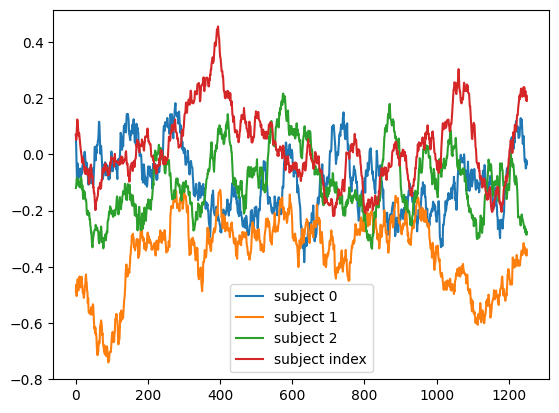

In [28]:
index = all_subject.index('PT036')

plt.figure() 
plt.plot(np.mean(mdd_subject_base[0,:,:,0], axis=-1), label='subject 0')
plt.plot(np.mean(mdd_subject_base[1,:,:,0], axis=-1), label='subject 1')
plt.plot(np.mean(mdd_subject_base[2,:,:,0], axis=-1), label='subject 2')
plt.plot(np.mean(mdd_subject_base[index,:,:,0], axis=-1), label='subject index')
plt.legend()

In [38]:
cli_path = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/cyrus_follow-up/data-information/fNIRS x MDD Data_Demographics_Clinical.xlsx'


id = 'PT002'

num_subject = 46 
label = []

excel_data = pd.read_excel(cli_path, sheet_name='Summary T0T8_fNIRS Analysis')


hamd_of_id_t1 = excel_data[excel_data['Subject ID'] == id]['HAM-D Questionnaire (T1)'].iloc[0]
hamd_of_id_t8 = excel_data[excel_data['Subject ID'] == id]['HAM-D Questionnaire (T8)'].iloc[0]
sub_label = [hamd_of_id_t1, hamd_of_id_t8]







25


Probe1(Deoxy),CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,CH9,CH10,CH11,CH12,CH13,CH14,CH15,CH16,CH17,CH18,CH19,CH20,CH21,CH22,CH23,CH24,CH25,CH26,CH27,CH28,CH29,CH30,CH31,CH32,CH33,CH34,CH35,CH36,CH37,CH38,CH39,CH40,CH41,CH42,CH43,CH44,CH45,CH46,CH47,CH48,CH49,CH50,CH51,CH52,Mark,Time

(1251, 52)


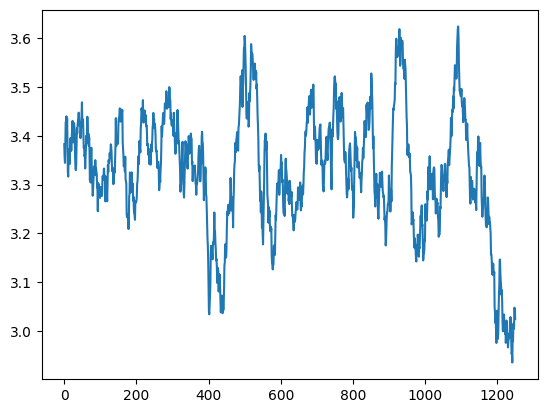

In [59]:
example_path_1 = '/Users/shanxiafeng/Documents/Project/Research/fnirs_mdd/cyrus_follow-up/data-information/Baseline_fnirs/Controls/CT074 VFT_HBA_Probe1_Deoxy.csv'
example_path_2 = '/Users/shanxiafeng/Documents/Project/Research/fnirs_mdd/cyrus_follow-up/data-information/Baseline_fnirs/Controls/MES/CT074 VFT_MES_Probe1.csv'


for example_path in [example_path_1]:   
    ch_data = read_from_file(example_path)
    mean_data = np.mean(ch_data, axis=1)
    plt.plot(mean_data)

print(ch_data.shape)